In [1]:
import os

from google.colab import drive
drive.mount('/content/gdrive')

os.chdir('/content/gdrive/MyDrive/first_try_of_fastai')

print("------------------------------------------------------------------")

Mounted at /content/gdrive
------------------------------------------------------------------


In [2]:
#export
import os
os.chdir('/content/gdrive/MyDrive/first_try_of_fastai/exp')
from nb_04 import *
os.chdir('/content/gdrive/MyDrive/first_try_of_fastai')

**Initial Setup**

In [3]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh,bs = 50, 512
c=y_train.max().item()+1
loss_func = F.cross_entropy

In [4]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
#export
def create_learner(model_func, loss_func, data):
  return Learner(*model_func(data), loss_func, data)

In [6]:
learn = create_learner(get_model,loss_func, data)
run = Runner(AvgStatsCallback([accuracy]))

run.fit(3, learn)

train: [0.65966265625, tensor(0.8063)]
valid: [0.3347951416015625, tensor(0.9038)]
train: [0.30466939453125, tensor(0.9106)]
valid: [0.2446790283203125, tensor(0.9317)]
train: [0.24742455078125, tensor(0.9288)]
valid: [0.2084046875, tensor(0.9431)]


In [7]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)


train: [0.753770625, tensor(0.8079)]
valid: [0.372559423828125, tensor(0.8865)]
train: [0.3436655859375, tensor(0.9013)]
valid: [0.294536669921875, tensor(0.9138)]
train: [0.29454033203125, tensor(0.9165)]
valid: [0.259019189453125, tensor(0.9248)]


In [8]:
#export
def get_model_func(lr=0.5): return partial(get_model, lr = lr)

In [9]:
#export

class Recorder(Callback):
  def begin_fit(self): self.lrs, self.losses = [],[]

  def after_batch(self):
    if not self.in_train: return
    self.lrs.append(self.opt.param_groups[-1]['lr'])
    self.losses.append(self.loss.detach().cpu())

  def plot_lr(self): plt.plot(self.lrs)
  def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
  _order = 1
  def __init__(self, pname, sched_func): self.pname, self.sched_func = pname,sched_func

  def set_param(self):
    for pg in self.opt.param_groups:
      pg[self.pname] = self.shed_func(self.n_epochs/self.epochs)

  def begin_batch(self):
    if self.in_train: self.set_param()


In [10]:
set_trace

<function IPython.core.debugger.set_trace>

In [19]:
def sched_lin(start, end):
  def _inner(start, end, pos): return start + pos*(end-start)
  return partial(_inner, start, end)

In [21]:
f = sched_lin(1,2)
f(0.3)

1.3

In [28]:
#export
def annealer(f):
  def _inner(start, end): return partial(f, start, end)
  return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [30]:
f = sched_lin(1,2)
f(0.4)

1.4

In [13]:
#sched_lin()

In [36]:
#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end - start) / 2
@annealer
def sched_no(start, end, pos): return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

In [37]:
torch.Tensor.ndim = property(lambda x: len(x.shape))

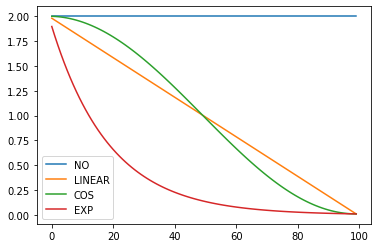

In [49]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0,100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend()

In [44]:
 #export
 def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts>=0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
      idx = (pos >= pcts).nonzero().max()
      actual_pos = (pos-pcts[idx]) / (pcts[idx+1] - pcts[idx])
      return scheds[idx](actual_pos)
    return _inner

In [45]:
sched = combine_scheds([0.3,0.7], [sched_cos(0.3,0.6), sched_cos(0.6,0.2)])

In [50]:
plt.plot(a, [sched(o) for o in p])

IndexError: ignored

In [51]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler,"lr", sched)]

In [52]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [53]:
run.fit(3,learn)

AttributeError: ignored

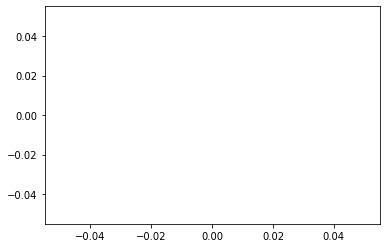

In [56]:
run.recorder.plot_lr()

In [57]:
run.recoder.plot_loss()

AttributeError: ignored

In [59]:
!pip install fire

     |████████████████████████████████| 92kB 4.1MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115928 sha256=a26e6a53fb4e18b907dd020018315c187bb76a0ba839eee672692d509f5ab36b
  Stored in directory: /root/.cache/pip/wheels/af/19/30/1ea0cad502dcb4e66ed5a690279628c827aea38bbbab75d5ed
Successfully built fire


In [61]:
!python notebook2script.py 05_anneal.ipynb

Traceback (most recent call last):
  File "notebook2script.py", line 72, in <module>
    if __name__ == '__main__': fire.Fire(notebook2script)
  File "/usr/local/lib/python3.7/dist-packages/fire/core.py", line 141, in Fire
    component_trace = _Fire(component, args, parsed_flag_args, context, name)
  File "/usr/local/lib/python3.7/dist-packages/fire/core.py", line 471, in _Fire
    target=component.__name__)
  File "/usr/local/lib/python3.7/dist-packages/fire/core.py", line 681, in _CallAndUpdateTrace
    component = fn(*varargs, **kwargs)
  File "notebook2script.py", line 44, in notebook2script
    if not allFiles: notebook2scriptSingle(fname)
  File "notebook2script.py", line 55, in notebook2scriptSingle
    main_dic = json.load(open(fname,'r',encoding="utf-8"))
FileNotFoundError: [Errno 2] No such file or directory: '05_anneal.ipynb'
